In [3]:
#-- read data
# http://mlg.ucd.ie/datasets/bbc.html
import pandas as pd
import numpy as np
data = pd.read_feather("../data/raw_text_DF.feather")
data["category"] = pd.Categorical(data["category"])
print(data.shape)
X = data["text"]
Y = pd.get_dummies(data["category"])


(2225, 3)


# Remove common words

In [4]:
X

0       BT offers equal access to rivals\n\nBT has mov...
1       Boeing unveils new 777 aircraft\n\nUS aircraft...
2       German economy rebounds\n\nGermany's economy, ...
3       Israel looks to US for bank chief\n\nIsrael ha...
4       Ukraine strikes Turkmen gas deal\n\nUkraine ha...
                              ...                        
2220    Dutch watch Van Gogh's last film\n\nThe last f...
2221    Alicia Keys to open US Super Bowl\n\nR&B star ...
2222    Obituary: Dame Alicia Markova\n\nDame Alicia M...
2223    Russian film wins BBC world prize\n\nRussian d...
2224    Spider-Man creator wins profits\n\nSpider-Man ...
Name: text, Length: 2225, dtype: object

In [5]:
#-- create graph from text
from nltk import word_tokenize 
from nltk.util import ngrams
import nltk
import networkx as nx 
import pandas as pd 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/robert/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
nltk.download('stopwords')
from nltk.corpus import stopwords
def text2graph(text):
    #-- pre-processing text
    # lematization
    # name entity recognition
    # insertion of correct entity names
    # split text into tokens
    token = word_tokenize(text.lower())
    token= [t for t in token if t.isalnum()]
    token= [t for t in token if t in list(model.vocab)]
    token= [t for t in token if t not in stopwords.words('english')]

    # extract bigrams
    bigram = list(ngrams(token, 2)) 
    # skip bigrams with words having only one sign
    cor_bigrams = [(a,b) for a,b in bigram if len(a)>1 and len(b)>1]
    # create graph
    edge_dataFrame = pd.DataFrame(cor_bigrams)
    G = nx.from_pandas_edgelist(edge_dataFrame,0,1) 
    return G

[nltk_data] Downloading package stopwords to /home/robert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
#-- feature matrix
from gensim.models import KeyedVectors, Word2Vec
# Load vectors directly from the file
model = KeyedVectors.load_word2vec_format('./../models/GoogleNews-vectors-negative300.bin.gz', binary=True)
#model = Word2Vec.load('models/simple_word2vec.model')


In [ ]:
#-- SAVE adj, features, label
import pickle
from datetime import datetime as dt
now = dt.now() 

all_words = []

for ind in range(X.shape[0]):
    
    file = open("../data/graphs_per_doc/txt_graph"+ now.strftime("%H%M_%d%m%Y") + "_" + str(ind) + ".pkl",'wb')
    
    Graph = text2graph(X[ind])
    all_words.append(list(Graph.nodes))
    #featureMat_DF = featureMat(list(Graph.nodes))
    pickle.dump(Graph, file)
    #pickle.dump(featureMat_DF, file)
    pickle.dump(Y.iloc[ind], file)
    file.close()
print("All files saved")


index = 1
print(X[index])
Graph = text2graph(X[index])

In [ ]:
nx.write_graphml(Graph, "./DocumentGraph.graphml")

In [ ]:
Graph.nodes

In [ ]:
import itertools

all_words = list(np.unique(list(itertools.chain.from_iterable(all_words))))

# Access vectors for specific words with a keyed lookup:

X_list = list()
for x in all_words:
    if x in model.wv.vocab:
        X_list.append(model[x])
    else:
        X_list.append(np.random.uniform(0,1,model.wv.vector_size))

X_df = pd.DataFrame(X_list)


features = X_df
features_df = pd.DataFrame(features)
features_df = features_df.set_index(pd.Index(all_words))
file = open("data/graphs_per_doc/txt_features"+ now.strftime("%H%M_%d%m%Y") + "_" + str(ind) + ".pkl",'wb')

pickle.dump(features_df, file)

file.close()

In [ ]:
# spectral_layout, 
# spring_layout
nx.set_node_attributes(Graph, nx.spring_layout(Graph), name = "pos")
G = Graph
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

In [ ]:
import plotly.graph_objects as go

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

In [ ]:
node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

In [10]:
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

NameError: name 'go' is not defined

In [11]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

NameError: name 'G' is not defined

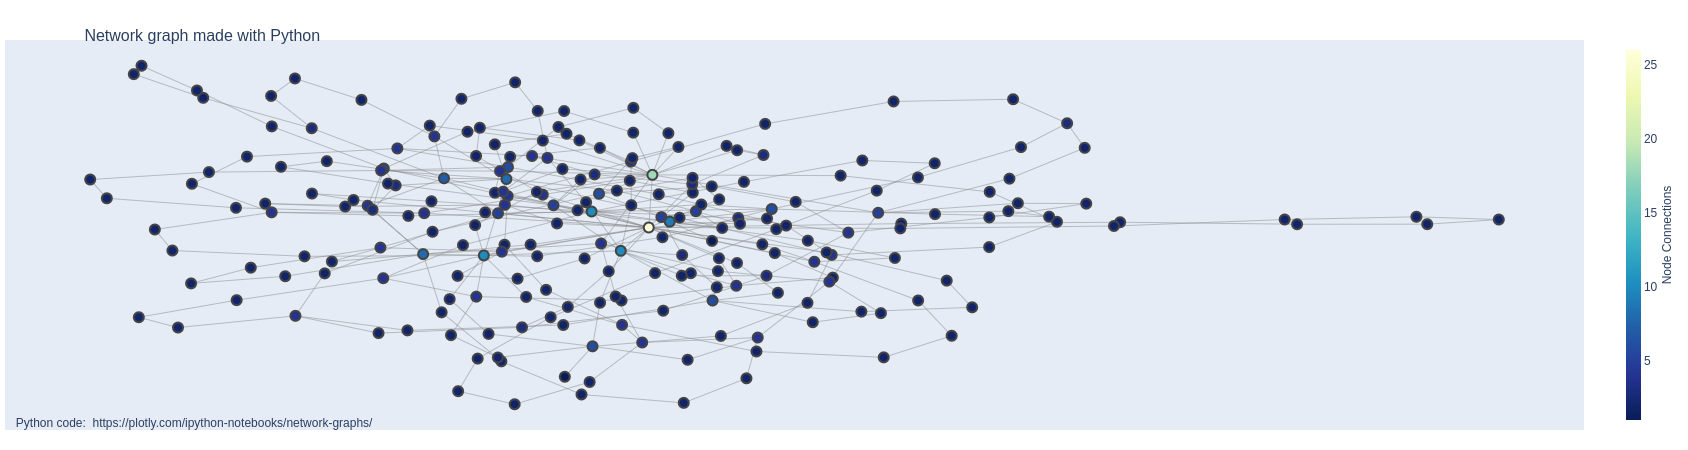

In [130]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()